In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Missing data

In [3]:
df_null = df_train.isnull().sum()
#print (len(df_null))
df1 = pd.DataFrame()
for idx_num in range(len(df_null)):
    if df_null.values[idx_num] != 0:
        df_temp = pd.DataFrame(index = [df_null.index[idx_num]],data = [df_null.values[idx_num]])
        df1 = df1.append(df_temp)
print (df1)

                 0
LotFrontage    259
Alley         1369
MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
FireplaceQu    690
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
PoolQC        1453
Fence         1179
MiscFeature   1406


In [4]:
# handle the missing data

# Alley : NA means no alley, so change it to 'None'
df_train.loc[:,'Alley'] = df_train.loc[:,'Alley'].fillna('None')
# FireplaceQu : NA means no Fireplace
df_train.loc[:,'FireplaceQu'] = df_train.loc[:,'FireplaceQu'].fillna('None')
# PoolQC : NA means no pool
df_train.loc[:,'PoolQC'] = df_train.loc[:,'PoolQC'].fillna('None')
# Fence : NA means no fence
df_train.loc[:,'Fence'] = df_train.loc[:,'Fence'].fillna('None')
# MiscFeature : NA means no feature, and its MiscVal should be 0
df_train.loc[:,'MiscFeature'] = df_train.loc[:,'MiscFeature'].fillna('None')
## LotFrontage : make it 0 first
df_train.loc[:,'LotFrontage'] = df_train.loc[:,'LotFrontage'].fillna(0)
## MasVnrType : NaN most likely to be None, make it None first
df_train.loc[:,'MasVnrType'] = df_train.loc[:,'MasVnrType'].fillna('None')
## MasVnrArea : NaN is the same with MasVnrType, make it 0 first
df_train.loc[:,'MasVnrArea'] = df_train.loc[:,'MasVnrArea'].fillna(0)
# BsmtQual : NA means no basement 
df_train.loc[:,'BsmtQual'] = df_train.loc[:,'BsmtQual'].fillna('None')
# BsmtCond : NA means no basement
df_train.loc[:,'BsmtCond'] = df_train.loc[:,'BsmtCond'].fillna('None')
# BsmtExposure : NA means no basement, but index 948 is strange, based on other data with unfinished basement, the Nan is mostly 'No'
df_train.loc[948,'BsmtExposure'] = 'No'
df_train.loc[:,'BsmtExposure'] = df_train.loc[:,'BsmtExposure'].fillna('None')
# BsmtFinType1 : NA means no basement
df_train.loc[:,'BsmtFinType1'] = df_train.loc[:,'BsmtFinType1'].fillna('None')
# BsmtFinType2 : NA means no basement
df_train.loc[:,'BsmtFinType2'] = df_train.loc[:,'BsmtFinType2'].fillna('None')
# Electrical : only one NA, and hard to interpret, just drop the data
df_train = df_train[df_train['Electrical'].notnull()]
# GarageType, GarageYrBlt,GarageFinish,GarageQual,GarageCond : NA means no garage
df_train.loc[:,'GarageType'] = df_train.loc[:,'GarageType'].fillna('None')
df_train.loc[:,'GarageFinish'] = df_train.loc[:,'GarageFinish'].fillna('None')
df_train.loc[:,'GarageQual'] = df_train.loc[:,'GarageQual'].fillna('None')
df_train.loc[:,'GarageCond'] = df_train.loc[:,'GarageCond'].fillna('None')
## Tansfer GarageYrBlt later, fill in 0 first, then deal with it 
df_train.loc[:,'GarageYrBlt'] = df_train.loc[:,'GarageYrBlt'].fillna(0)


In [5]:
# handle categorical like feature value
# Survey the data, the features below are categorical type
# MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,
# Condition2,BldgType,HouseStyle,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,
# ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating
# HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,
# GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def apply_label_encoder(data,feature_name):
    le.fit(df_train[feature_name])
    data[feature_name] = le.transform(data[feature_name])

labelEncoder_list = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1',
'Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
'Foundation','BsmtFinSF1','Heating','CentralAir','Electrical','GarageYrBlt','Fence','MiscFeature','MoSold','YrSold','SaleType','SaleCondition']
for feature in labelEncoder_list:
    apply_label_encoder(df_train,feature)


def apply_qualify_encoder(data,feature_name):
    return data.replace({feature_name:{"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}})

qual_labelEncoder_list = ['ExterCond','ExterQual','HeatingQC','KitchenQual','BsmtQual','BsmtCond','FireplaceQu','GarageCond','GarageQual','PoolQC']    
for feature in qual_labelEncoder_list:
    df_train = apply_qualify_encoder(df_train,feature)
    
#special one
df_train = df_train.replace({"BsmtExposure" : {"None" : 0,"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                  "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                  "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                  "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                  "Min2" : 6, "Min1" : 7, "Typ" : 8},
                  "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                  "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                  "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                  "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                  "GarageFinish": {"None" : 0, "Unf":1, "RFn":2,"Fin":3},
                  "GarageType" : {"None":0, "Detchd":1, "CarPort":2, "BuiltIn":3, "Basment":4, "Attchd":5,"2Types":6}})

In [6]:
# drop 'Id', it is no relationship with SalePrice
df_train = df_train.drop('Id',axis=1)

## Correlation

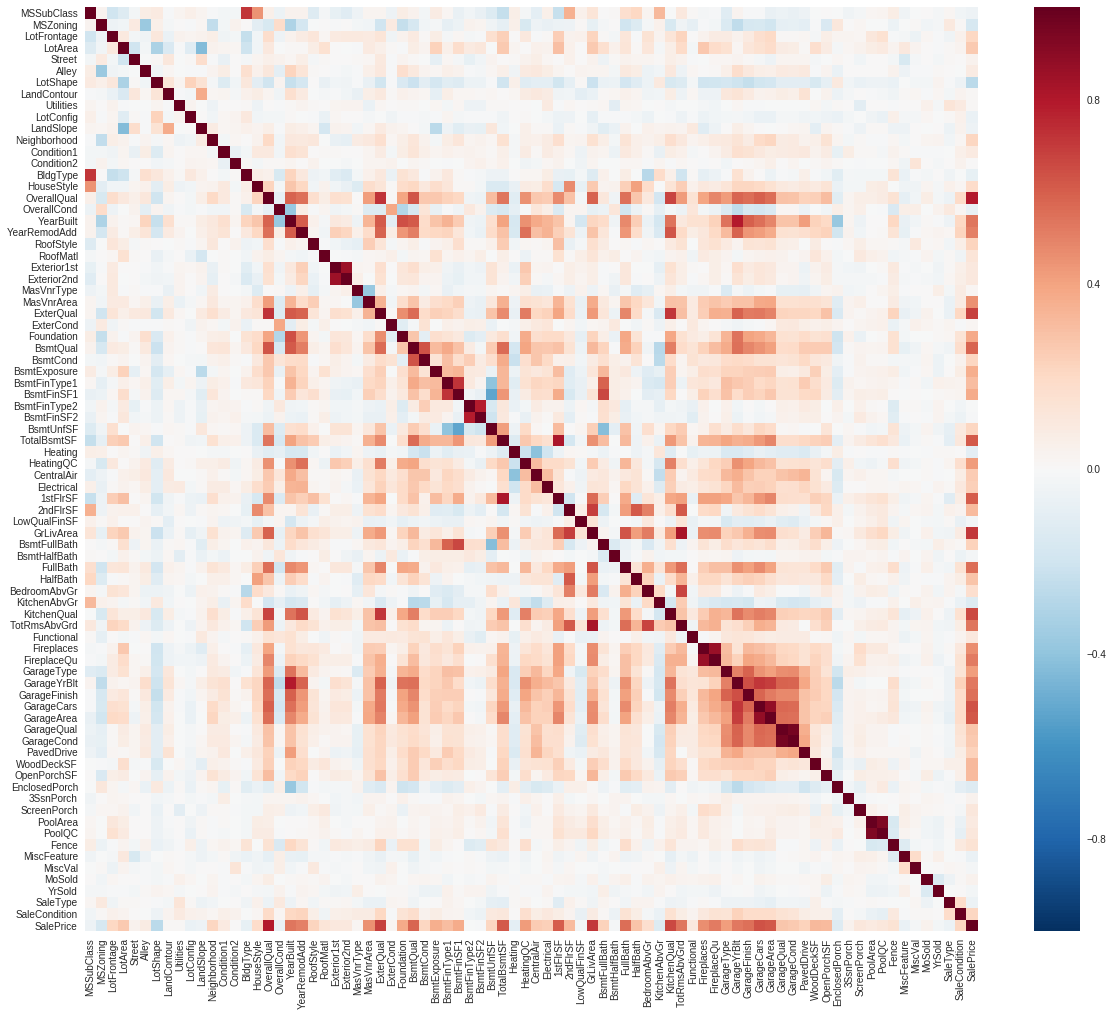

In [7]:
corrmat = df_train.corr()
f,ax = plt.subplots(figsize=(20,17))
sns.heatmap(corrmat)

In [8]:
corrmat.nlargest(len(df_train),'SalePrice')['SalePrice']

SalePrice        1.000000
OverallQual      0.791069
GrLivArea        0.708618
ExterQual        0.682677
KitchenQual      0.659814
GarageCars       0.640473
GarageArea       0.623423
TotalBsmtSF      0.613905
1stFlrSF         0.605968
BsmtQual         0.585349
FullBath         0.560881
GarageFinish     0.549809
YearBuilt        0.535346
TotRmsAbvGrd     0.533779
GarageYrBlt      0.527901
FireplaceQu      0.520507
YearRemodAdd     0.507430
Fireplaces       0.466968
MasVnrArea       0.458195
HeatingQC        0.427639
GarageType       0.415266
Foundation       0.382671
BsmtFinSF1       0.368806
BsmtExposure     0.361843
WoodDeckSF       0.324422
2ndFlrSF         0.319464
OpenPorchSF      0.315831
BsmtFinType1     0.304923
HalfBath         0.284400
GarageQual       0.273879
                   ...   
Exterior1st      0.103658
PoolArea         0.092397
Condition1       0.091152
Alley            0.083125
MoSold           0.046380
3SsnPorch        0.044571
Street           0.041043
ExterCond   

## Outlier 

In [9]:
def data_observation(X_feature,y_feature):
    plt.scatter(df_train[X_feature], df_train[y_feature], c = "blue", marker = "s")
    plt.title("Observation of X and SalePrice")
    plt.xlabel(X_feature)
    plt.ylabel(y_feature)
    plt.show()

### QA : How to decide Qutlier?

In [10]:
# for i in df_train.columns:
#     if i != 'SalePrice':
#         data_observation(i,'SalePrice')

In [11]:
df_train[(df_train['LotFrontage']>250)]
df_train = df_train.drop([934,1298])
df_train[(df_train['MasVnrArea']<50)&(df_train['SalePrice']>700000)]
df_train = df_train.drop([1182])
df_train[(df_train['BsmtFinSF1']>50)&(df_train['SalePrice']>500000)].loc[:,'BsmtFinSF1']
df_train = df_train.drop([1046])
# df_train[(df_train['GrLivArea']>5000)]
# df_train = df_train.drop([1298])
df_train[(df_train['GarageYrBlt']>60)&(df_train['SalePrice']>620000)]
df_train = df_train.drop([691,1169])
df_train[(df_train['OpenPorchSF']>500)&(df_train['SalePrice']<100000)]
df_train = df_train.drop([495])
df_train[(df_train['YearBuilt']>80) & (df_train['SalePrice']>600000)]
df_train = df_train.drop([898])
df_train[(df_train['YearBuilt']<20) & (df_train['SalePrice']>400000)]
df_train = df_train.drop([185])
# df_train[(df_train['TotalBsmtSF']>5000)]
# df_train = df_train.drop([1298])
df_train[(df_train['1stFlrSF']>2700)]
df_train = df_train.drop([496,523,1024])

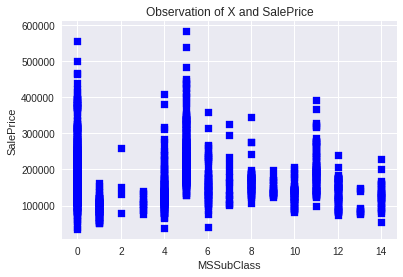

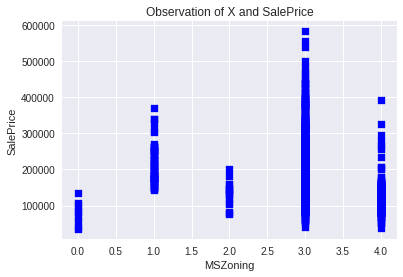

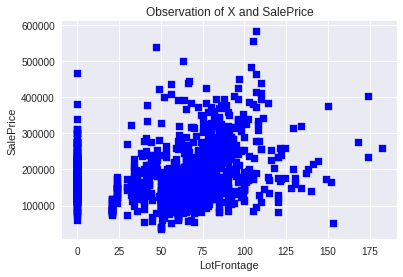

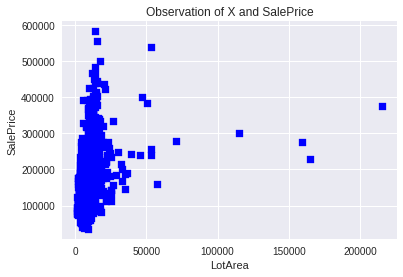

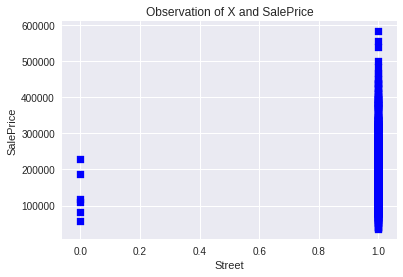

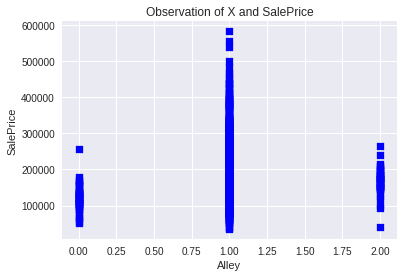

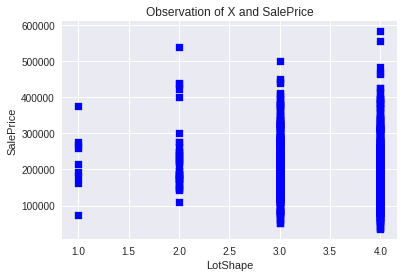

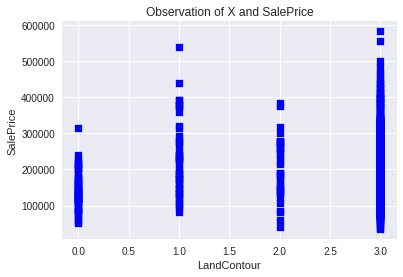

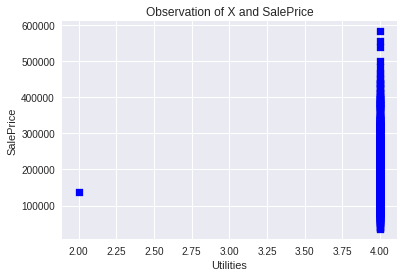

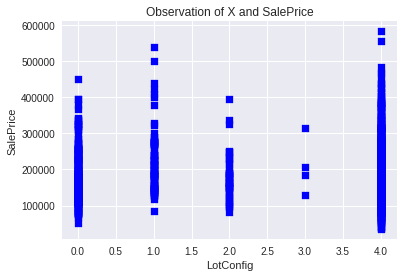

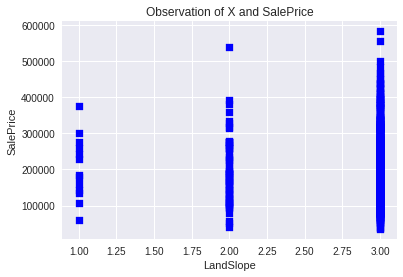

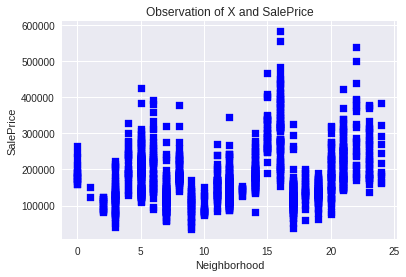

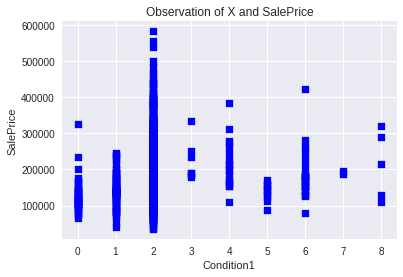

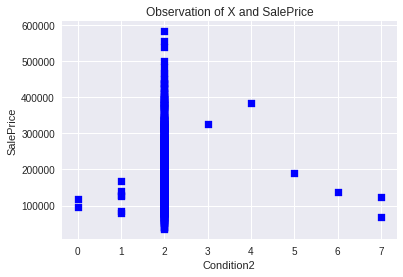

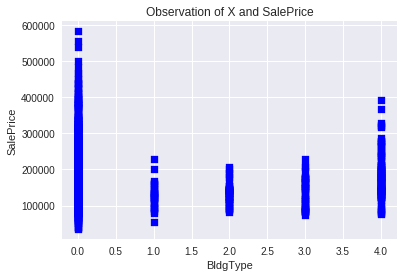

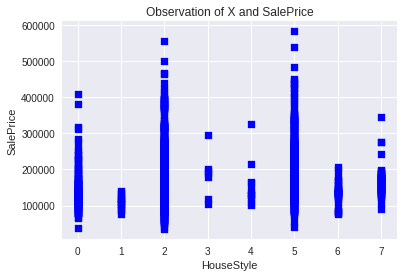

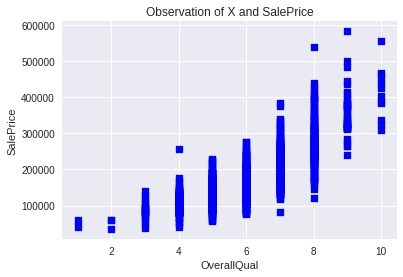

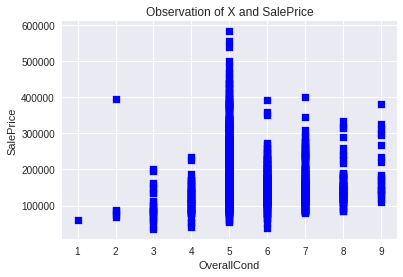

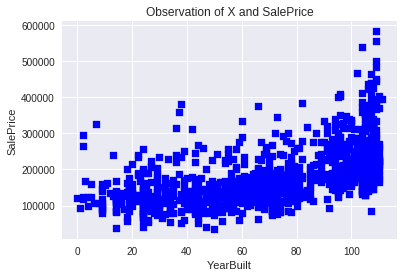

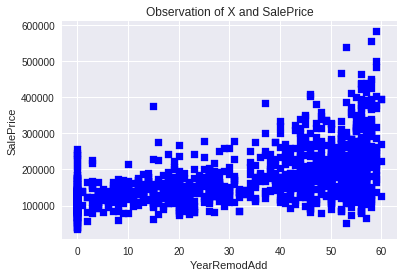

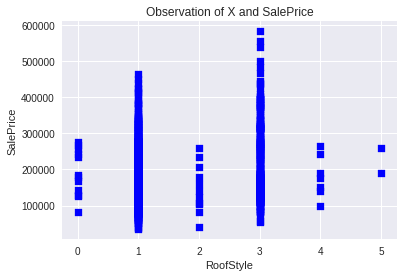

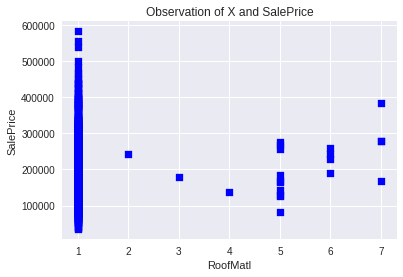

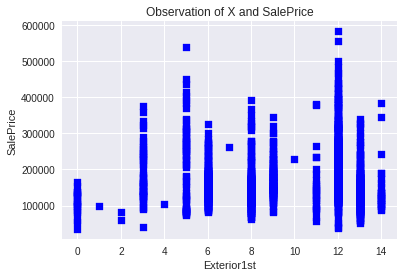

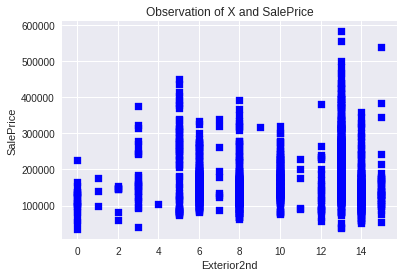

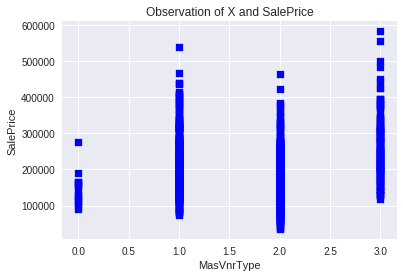

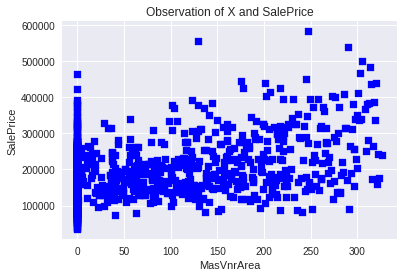

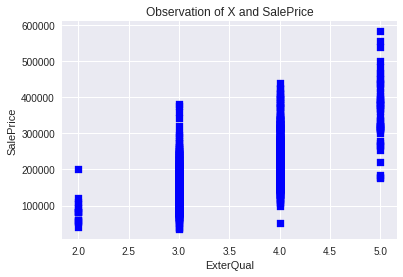

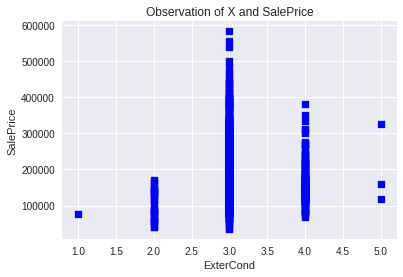

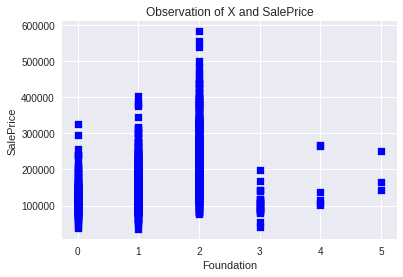

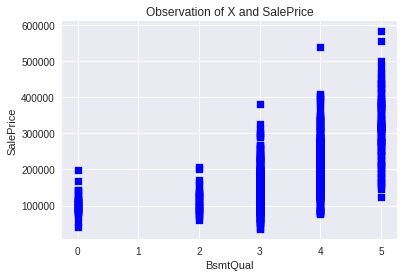

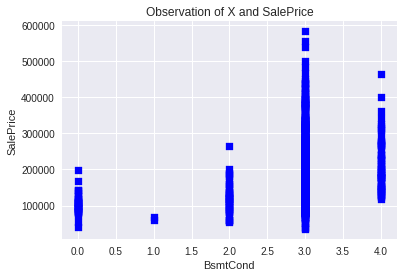

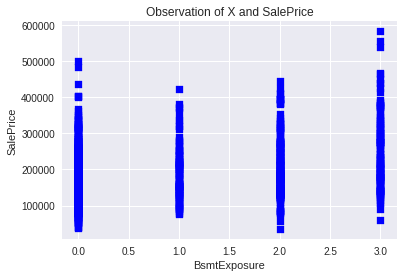

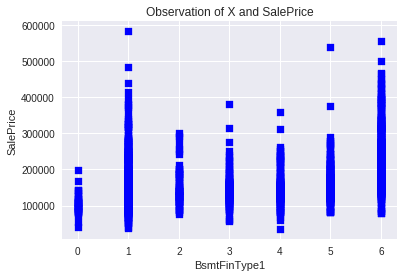

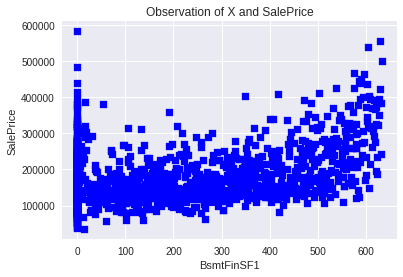

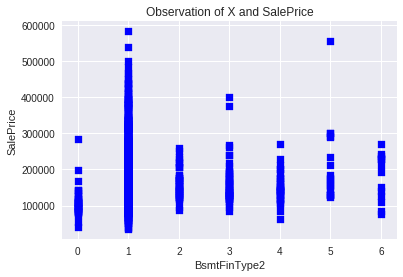

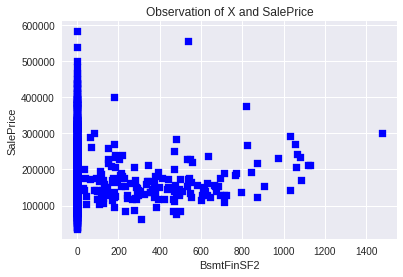

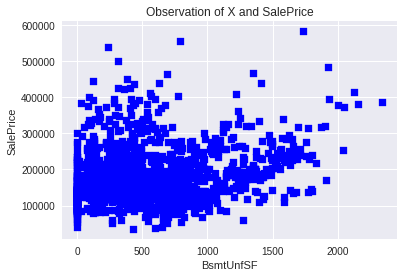

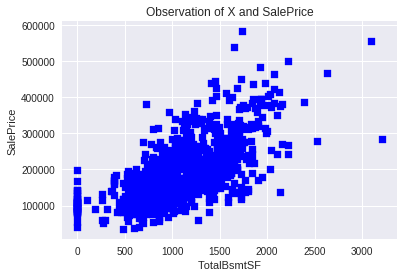

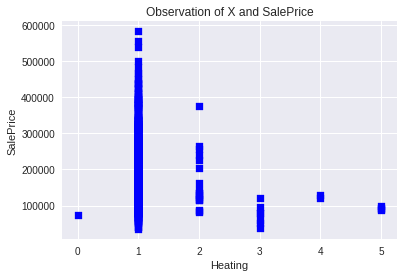

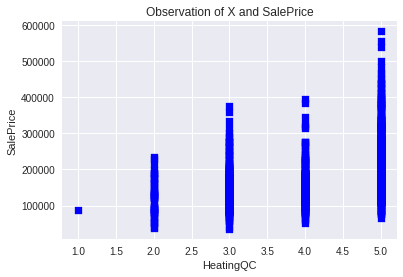

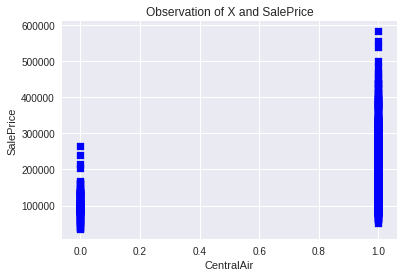

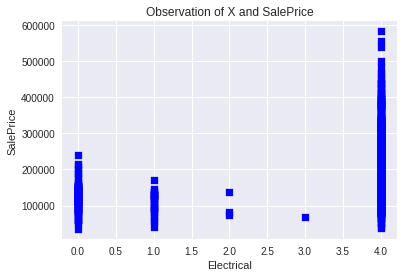

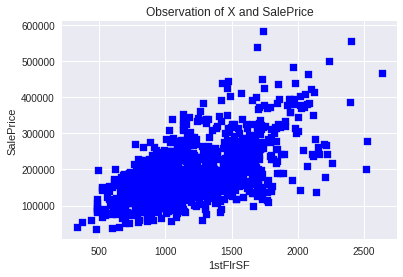

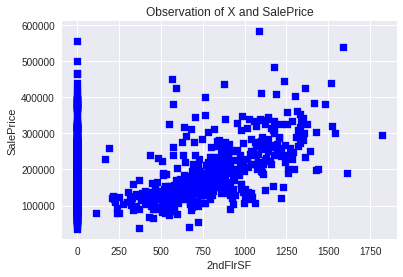

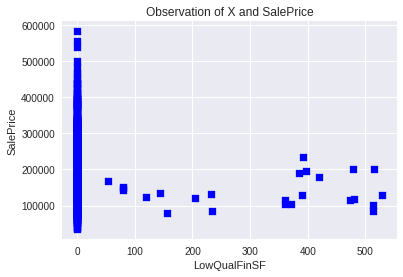

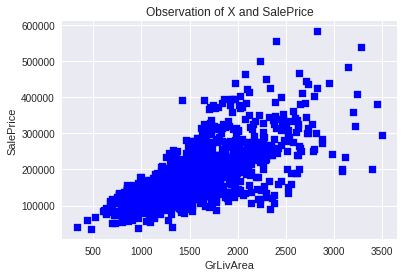

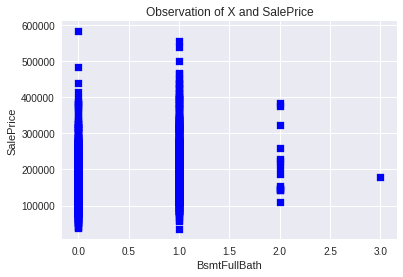

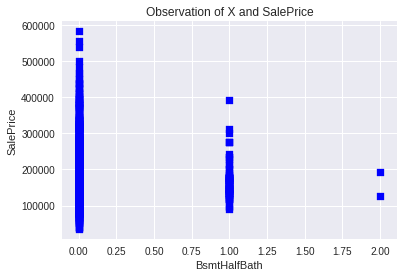

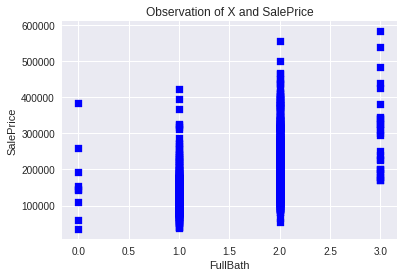

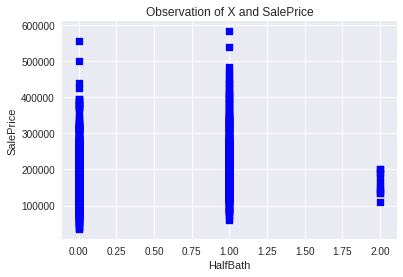

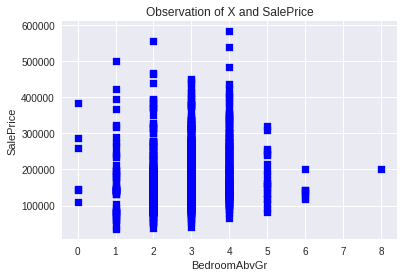

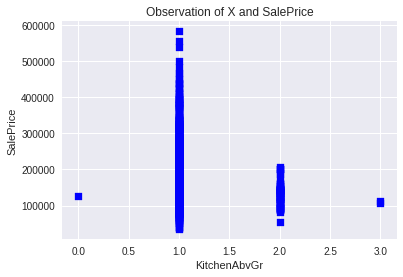

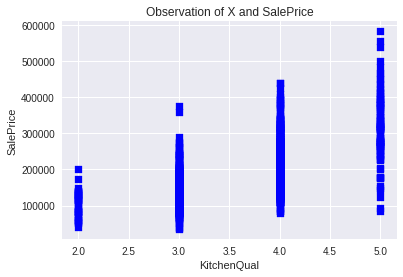

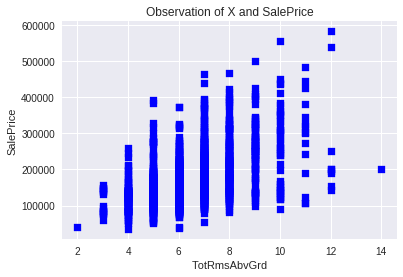

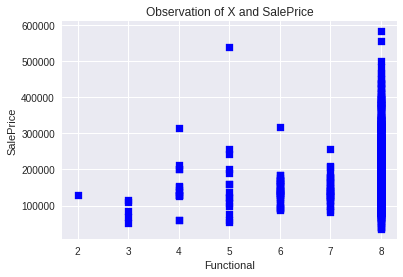

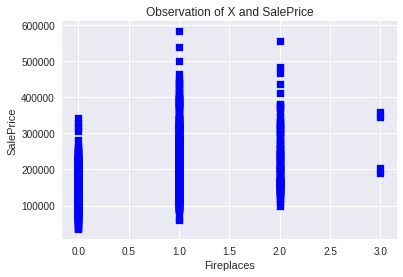

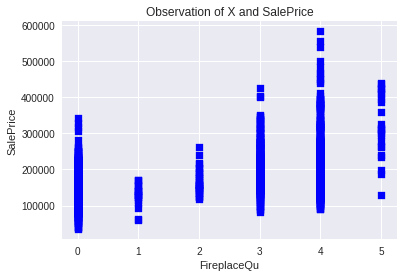

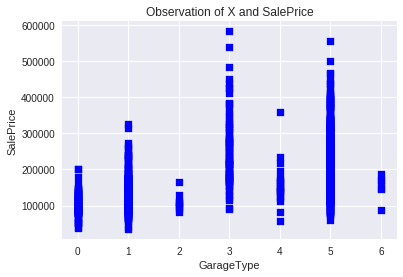

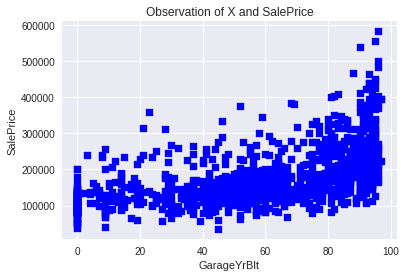

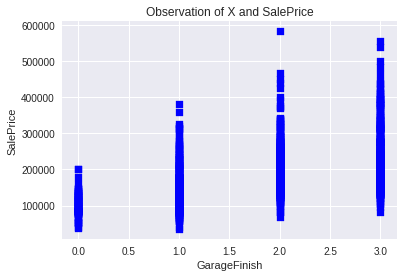

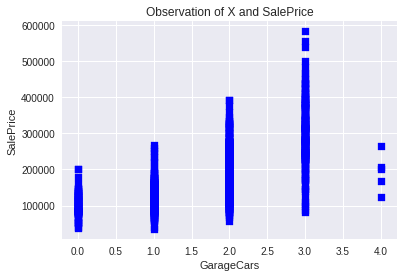

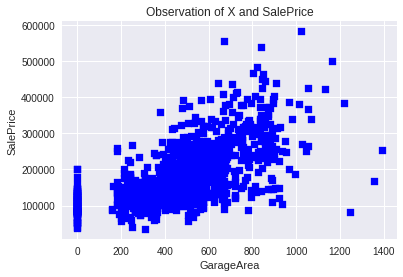

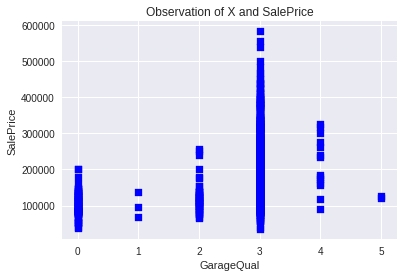

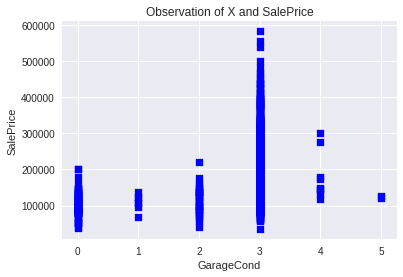

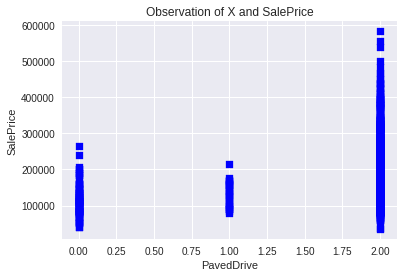

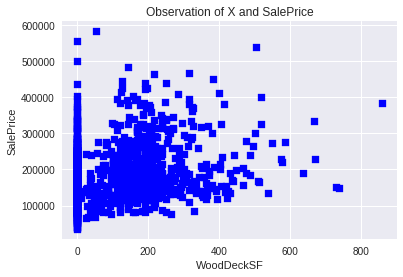

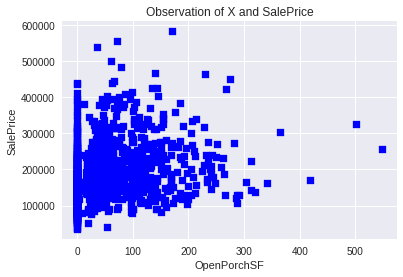

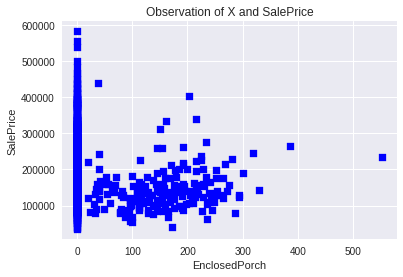

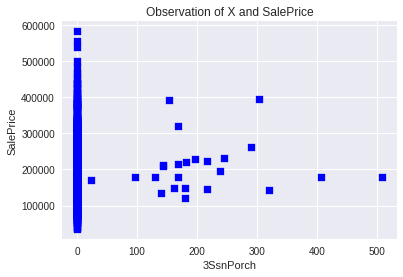

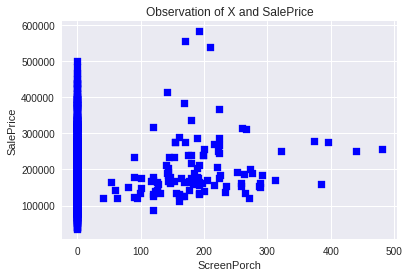

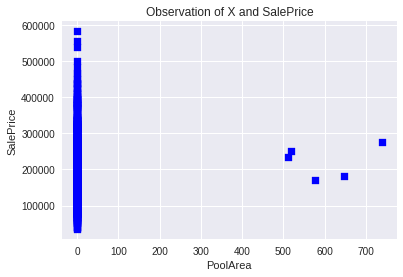

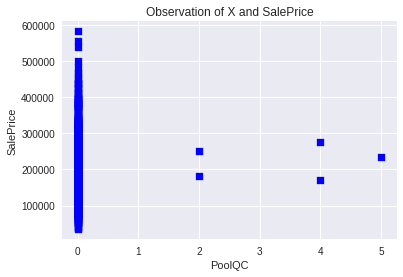

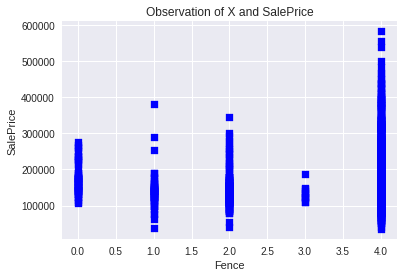

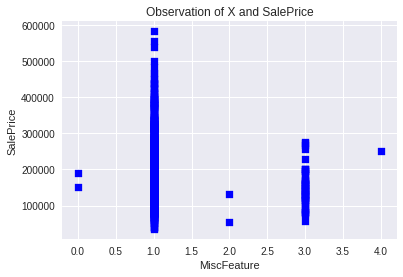

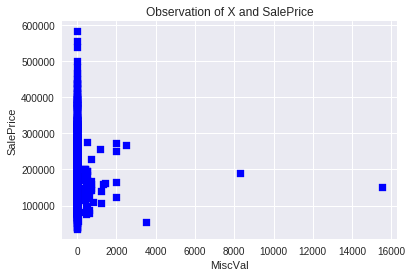

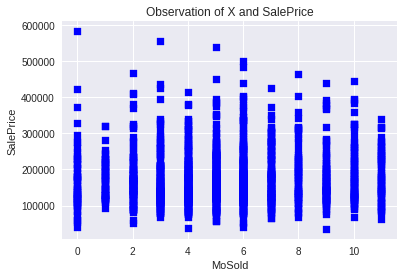

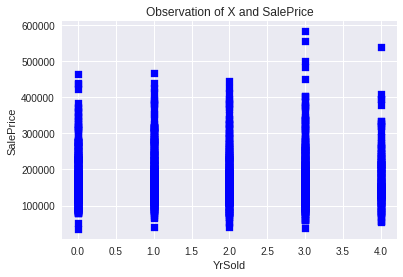

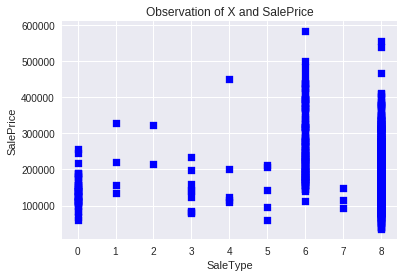

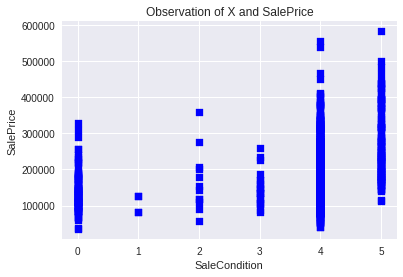

In [12]:
for i in df_train.columns:
    if i != 'SalePrice':
        data_observation(i,'SalePrice')

## Feature Selection and transform

Based on the correlation heap map, choose some highly correlated (positive and negative) features to transfrom.

In [13]:
from sklearn import linear_model
from sklearn.model_selection import KFold


def simple_linear_test(train_data,n_fold,feature_list):
    # use n-fold Cross validation 
    kf = KFold(n_fold).split(train_data)
    reg = linear_model.LinearRegression()
    part = 0
    total = 0
    y_train_data = train_data.loc[:,'SalePrice']
    X_train_data = train_data.drop('SalePrice',axis=1).loc[:,feature_list]
    for train_idx,test_idx in kf:
        print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
        X_train, y_train = X_train_data.iloc[train_idx], y_train_data.iloc[train_idx]
        X_test, y_test = X_train_data.iloc[test_idx], y_train_data.iloc[test_idx]
        reg.fit(X_train,y_train)
        pred_test = reg.predict(X_test)
        part += 1
        pred_score = rmse(pred_test,y_test)
        total += pred_score
        print ("%d part RMSE: %.7f" % (part,pred_score))
    print ('Avg RMSE : ',total/n_fold) 

### QA: How to transform in a proper way?

1. some zero value have high SalePrice

2. how to manipulate the categorical feature to support the model

In [14]:
# Feature transform

# based on previous simple test, do it first is better
df_train['SalePrice'] = np.log(df_train['SalePrice'])

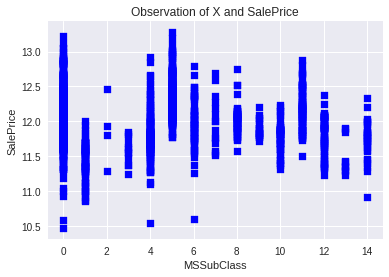

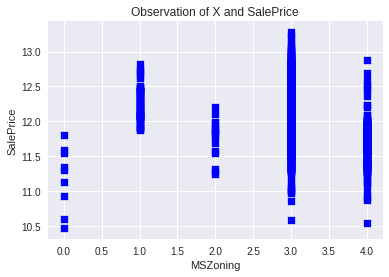

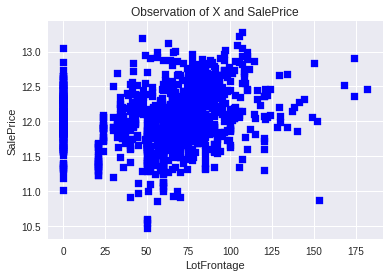

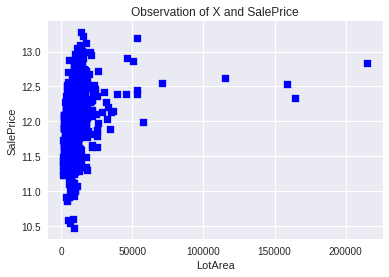

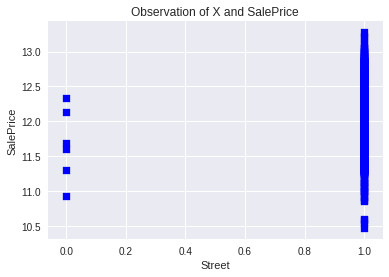

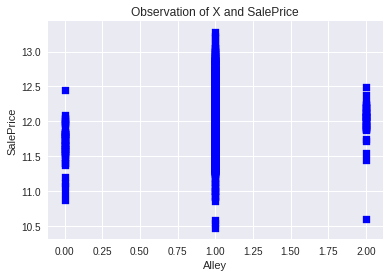

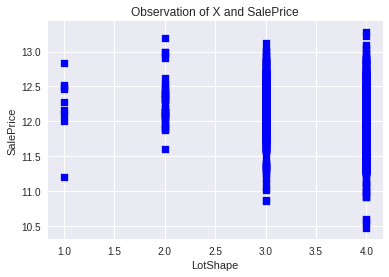

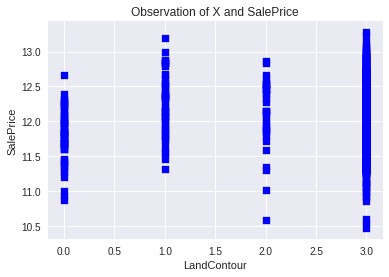

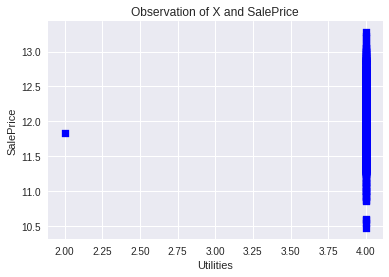

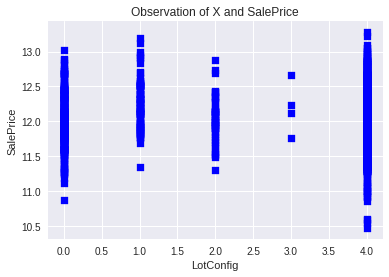

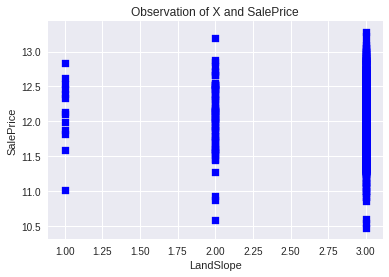

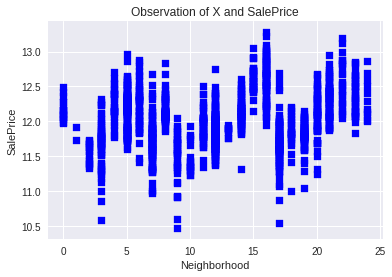

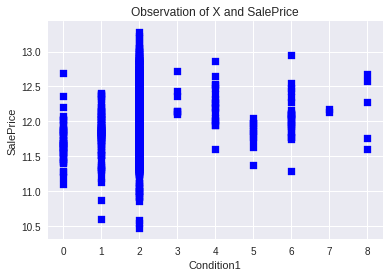

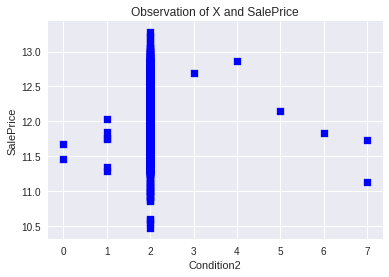

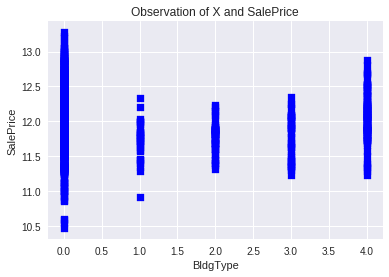

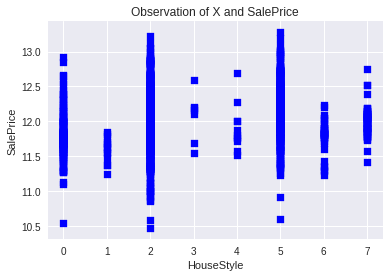

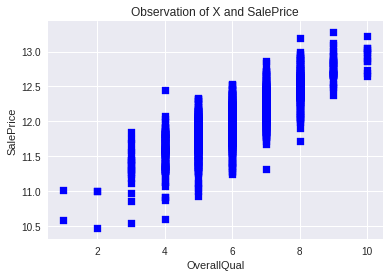

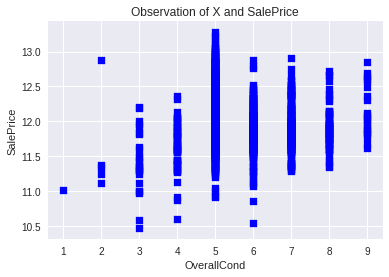

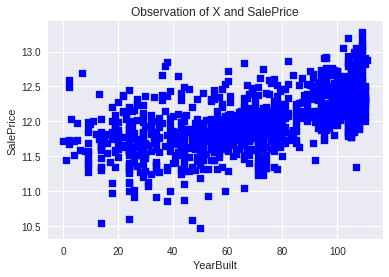

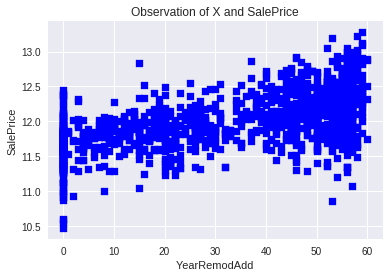

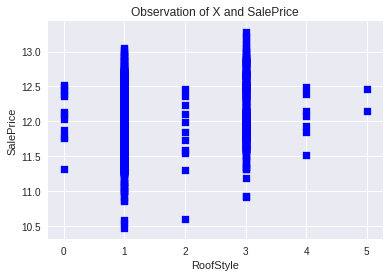

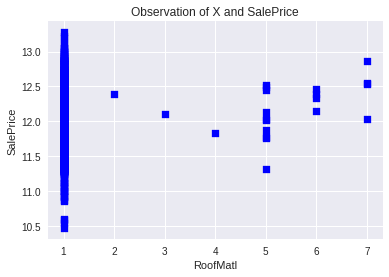

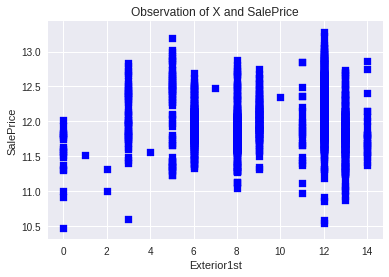

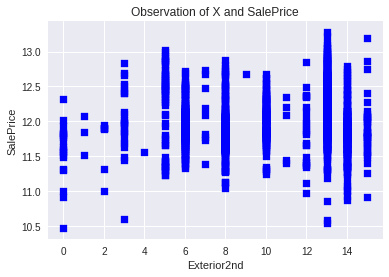

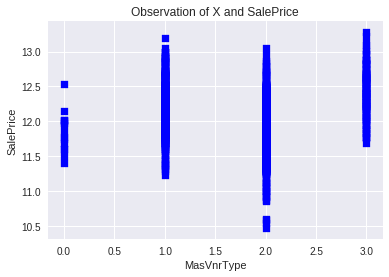

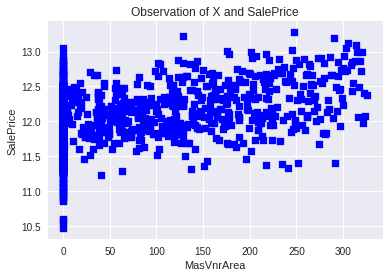

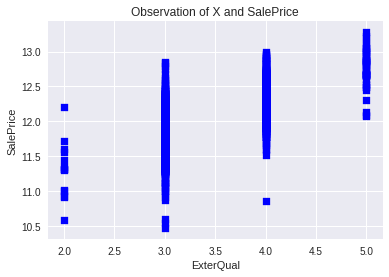

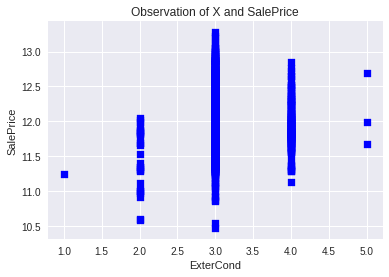

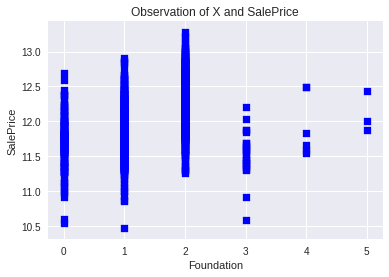

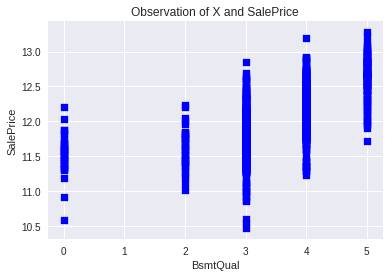

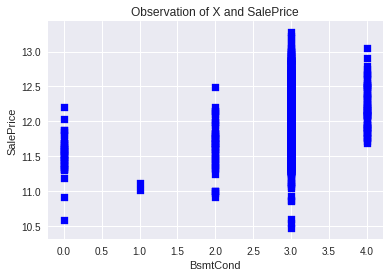

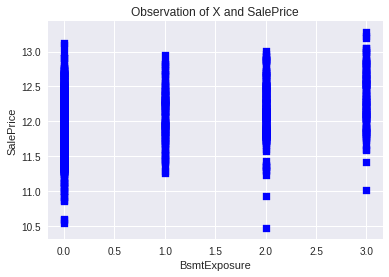

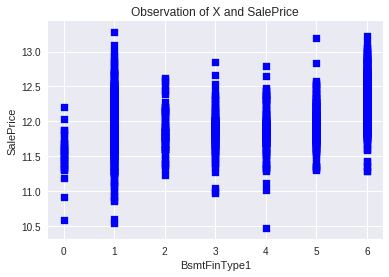

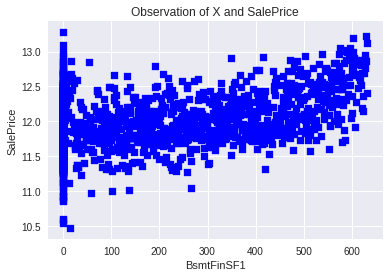

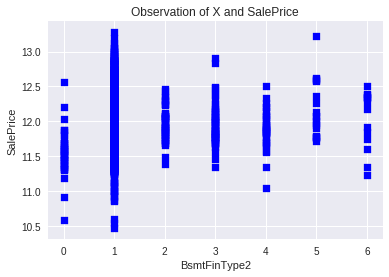

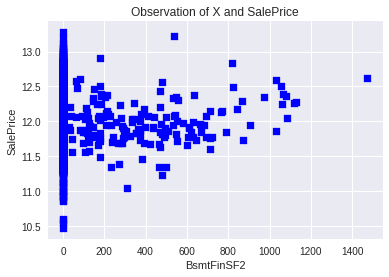

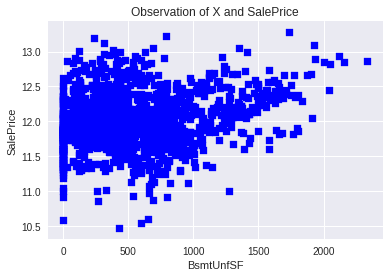

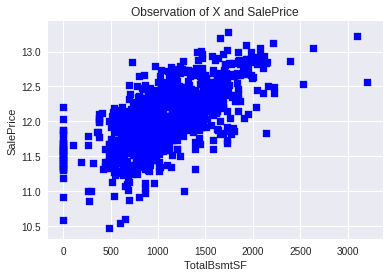

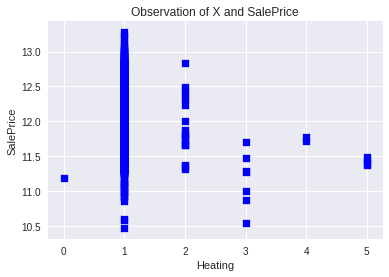

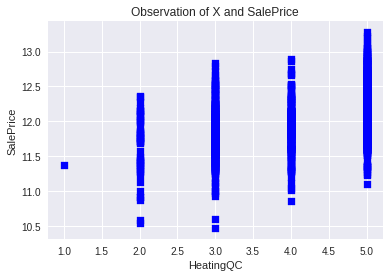

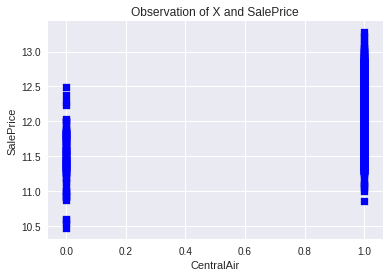

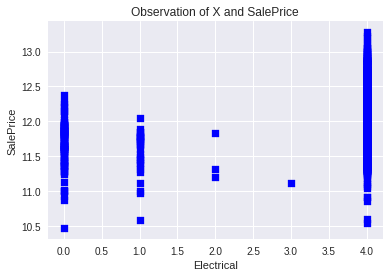

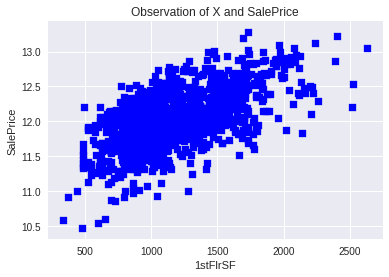

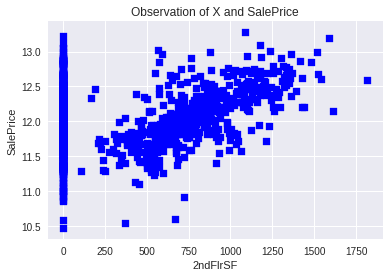

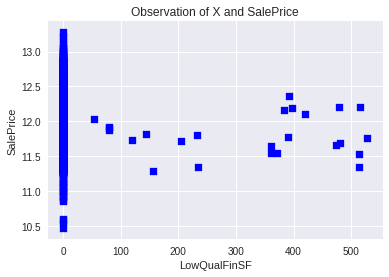

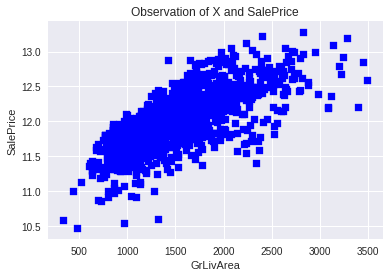

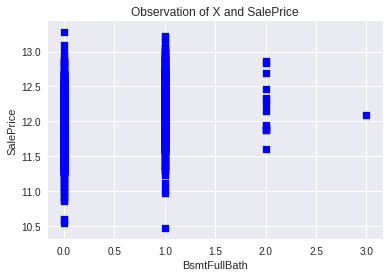

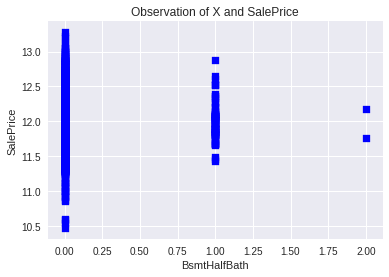

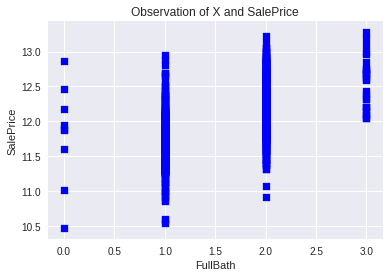

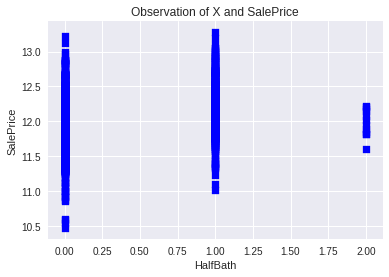

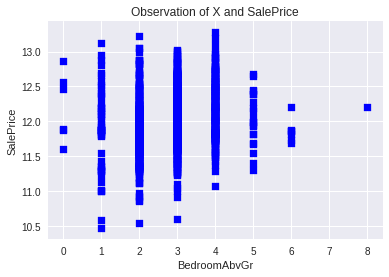

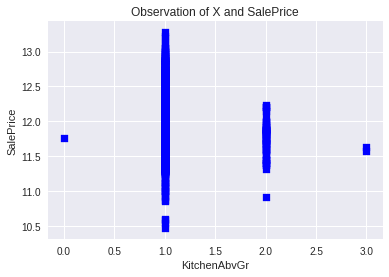

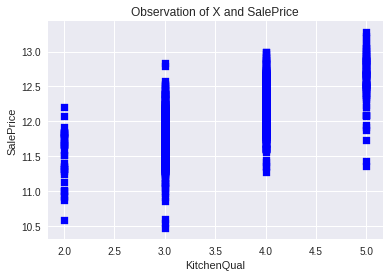

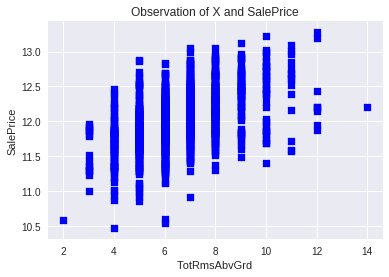

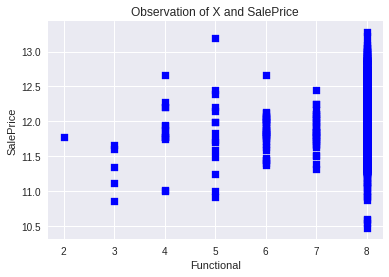

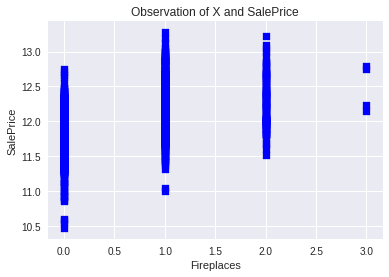

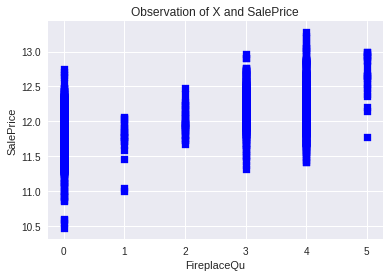

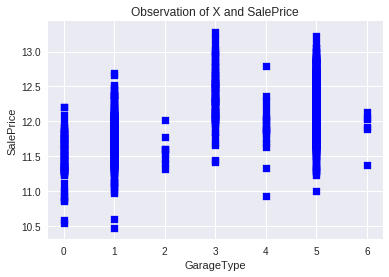

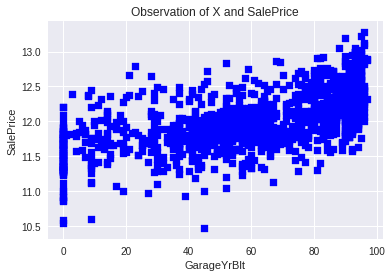

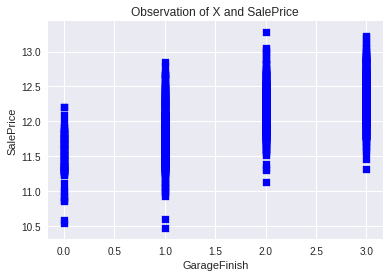

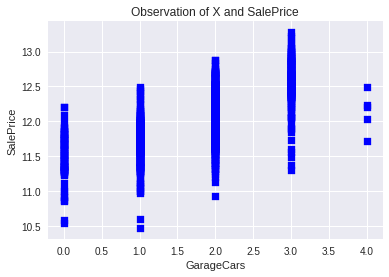

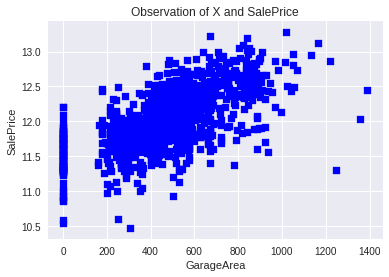

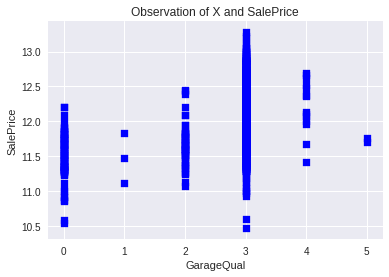

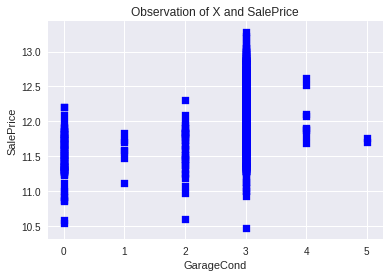

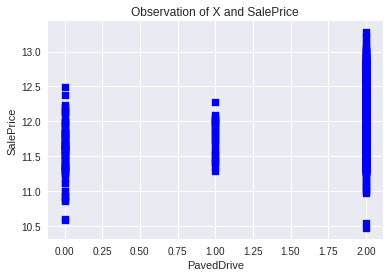

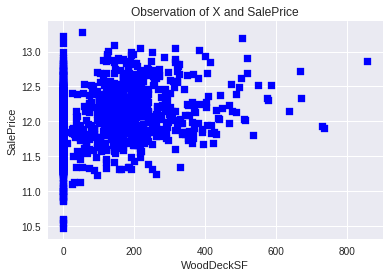

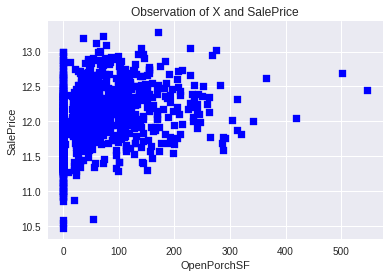

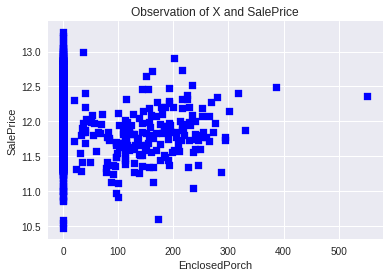

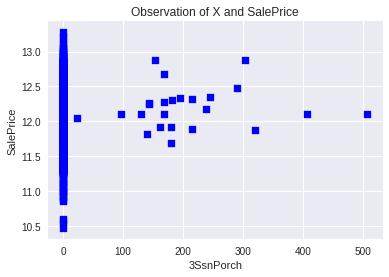

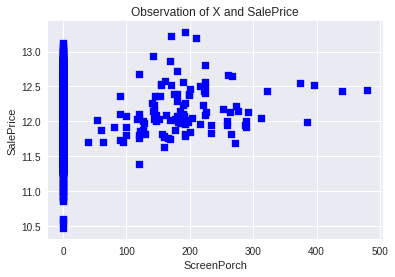

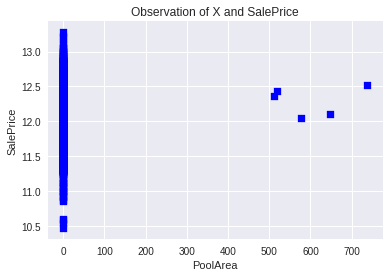

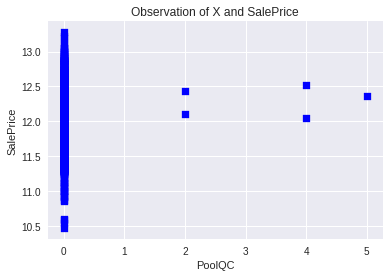

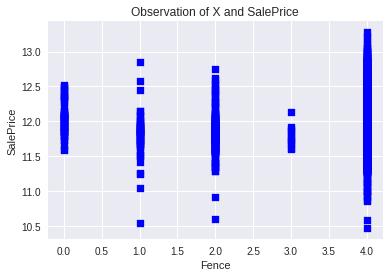

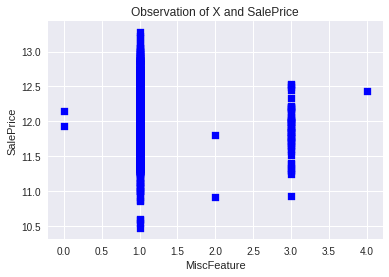

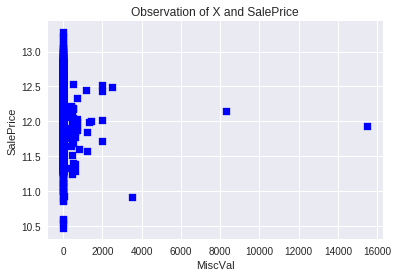

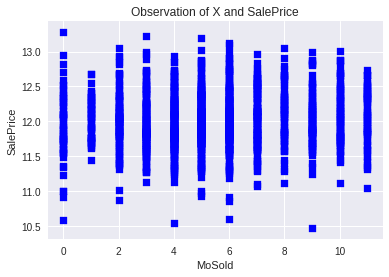

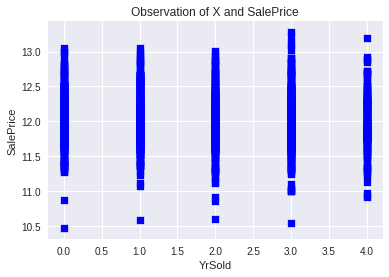

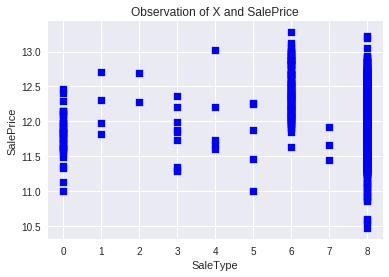

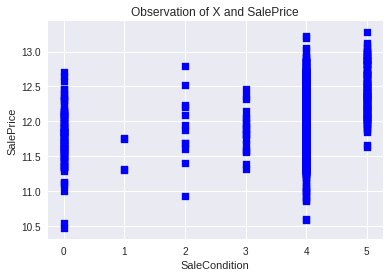

In [15]:
for i in df_train.columns:
    if i != 'SalePrice':
        data_observation(i,'SalePrice')

/home/bill9800/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


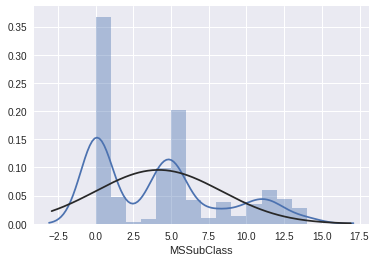

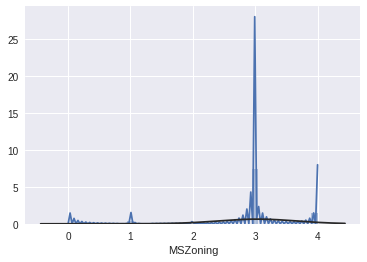

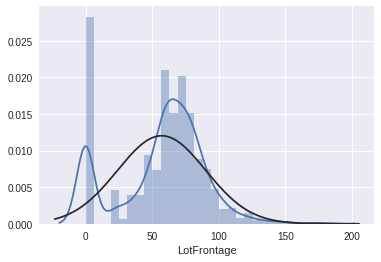

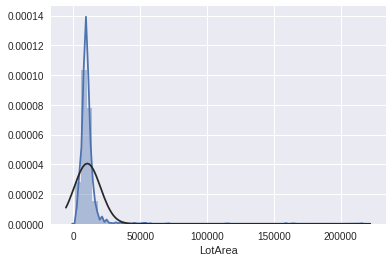

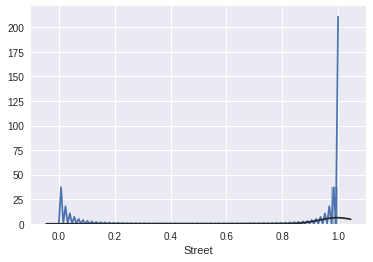

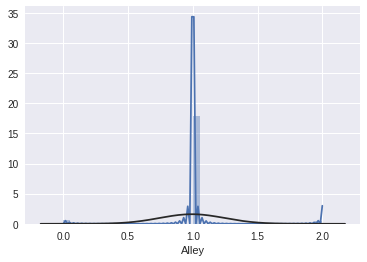

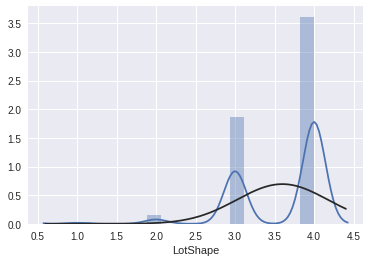

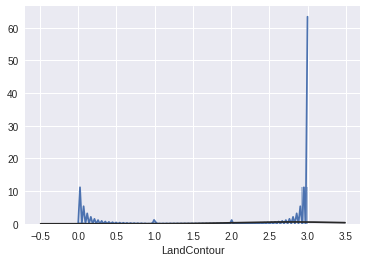

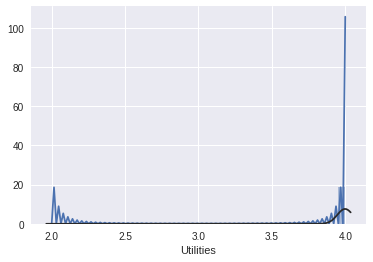

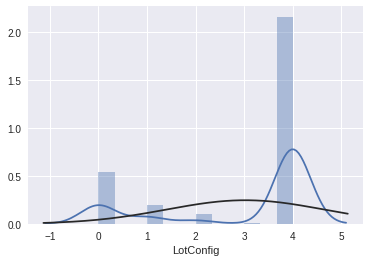

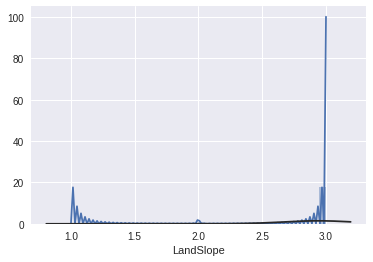

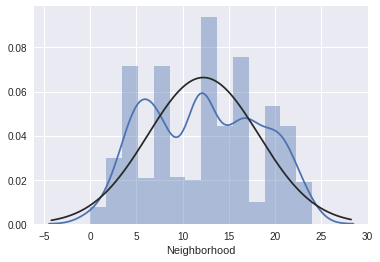

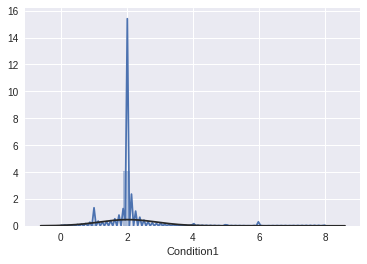

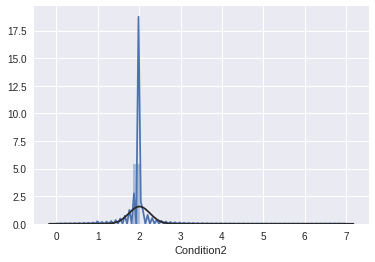

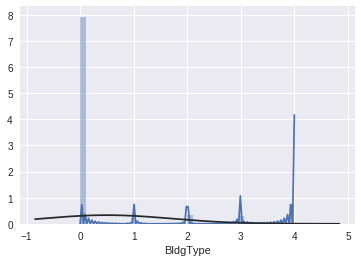

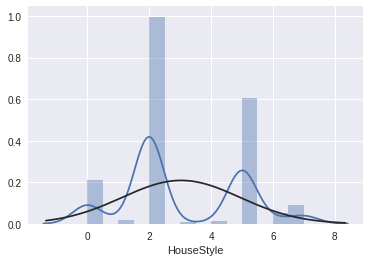

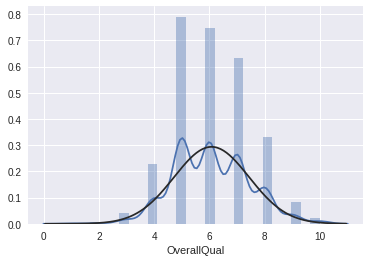

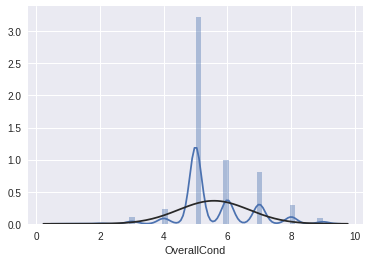

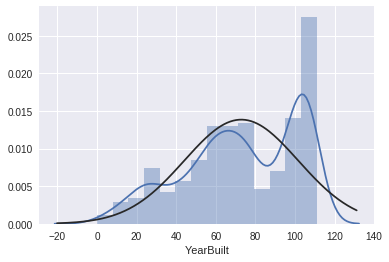

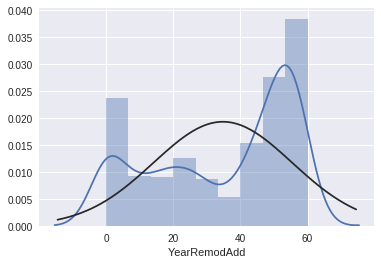

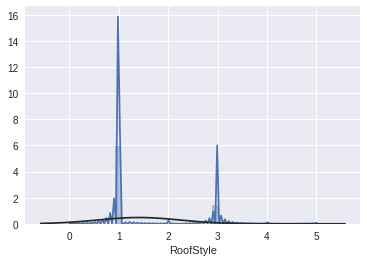

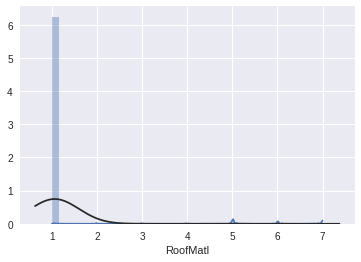

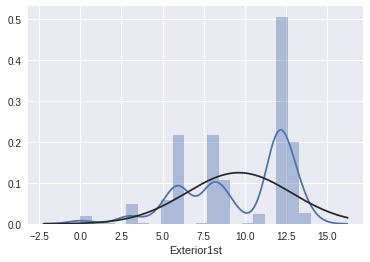

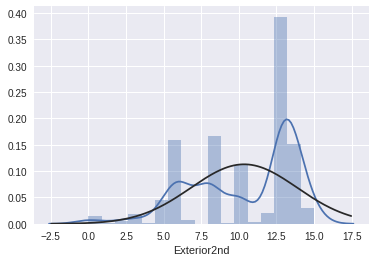

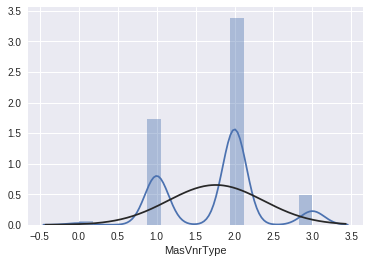

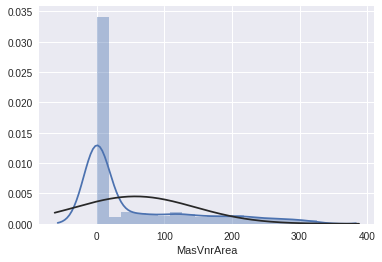

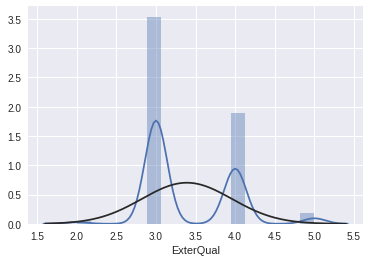

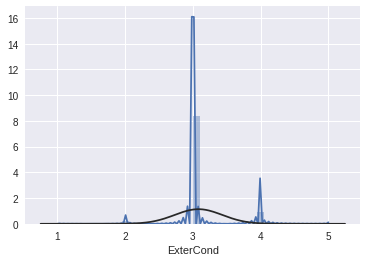

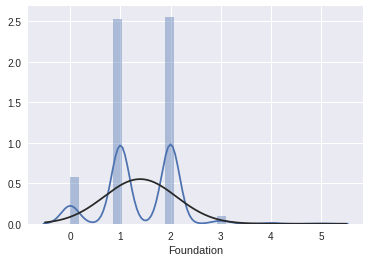

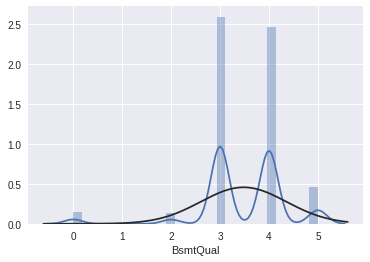

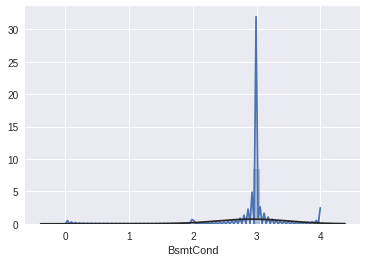

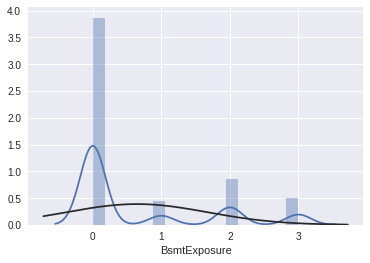

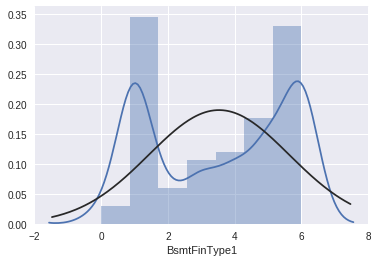

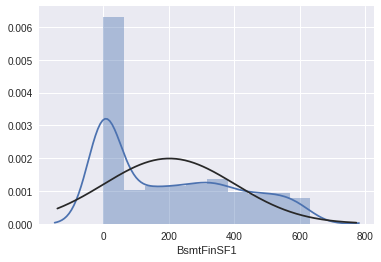

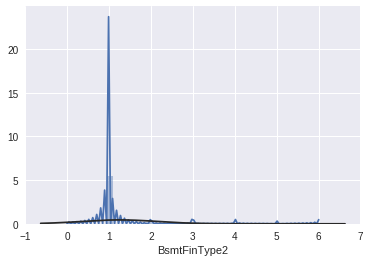

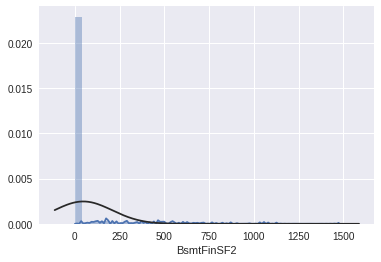

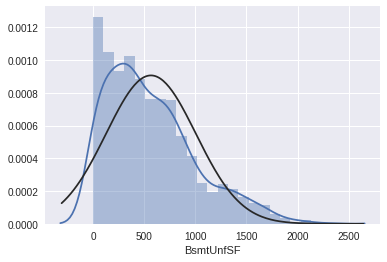

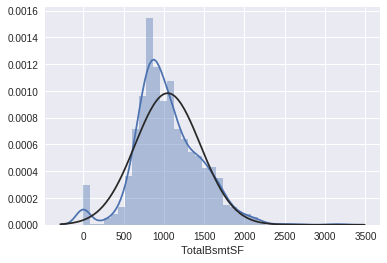

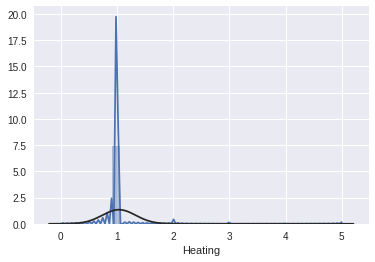

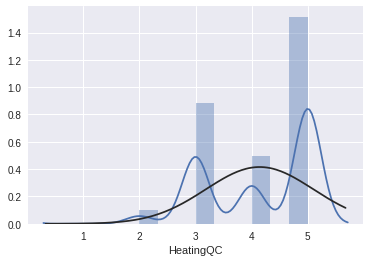

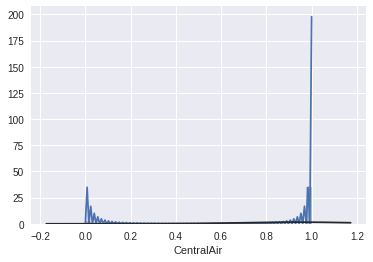

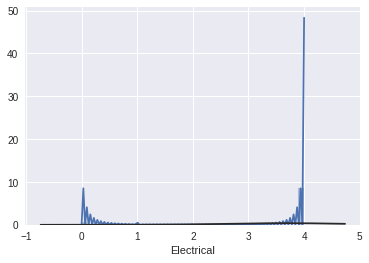

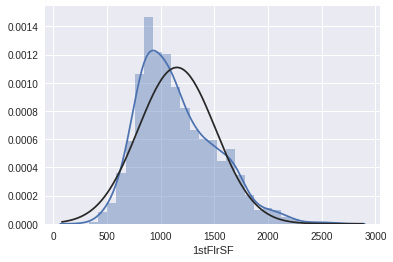

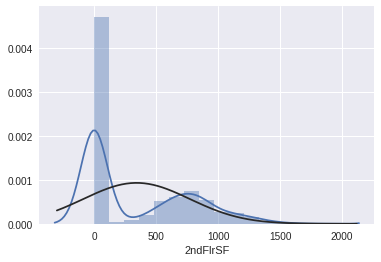

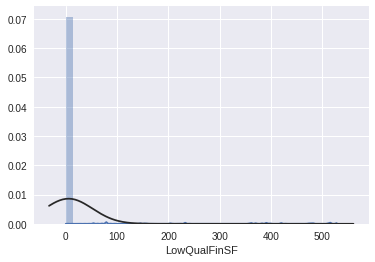

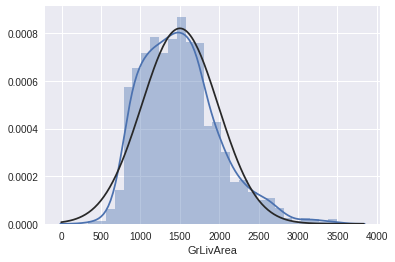

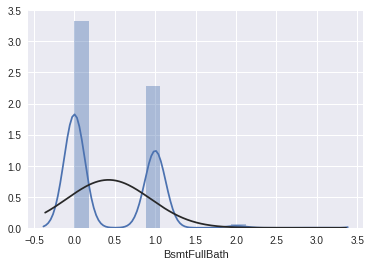

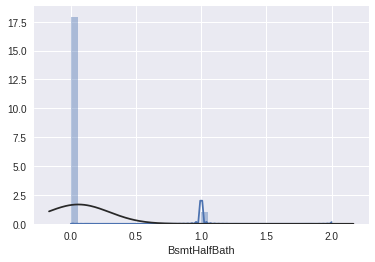

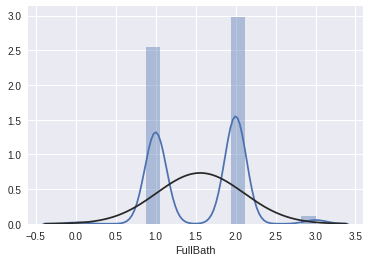

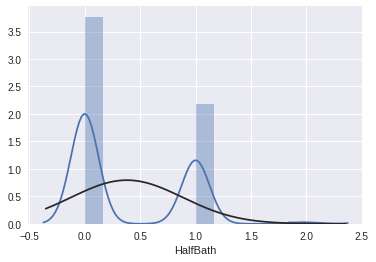

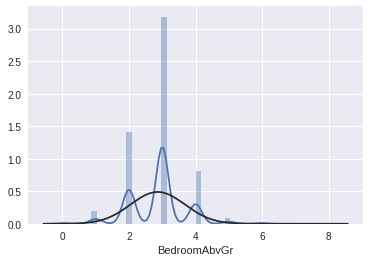

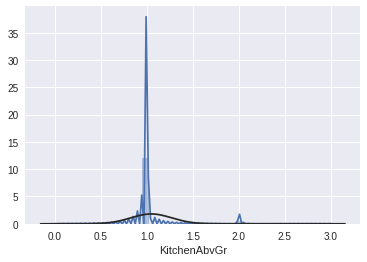

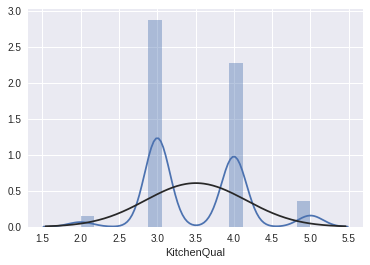

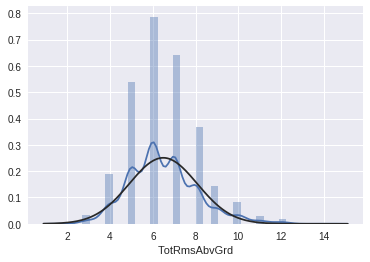

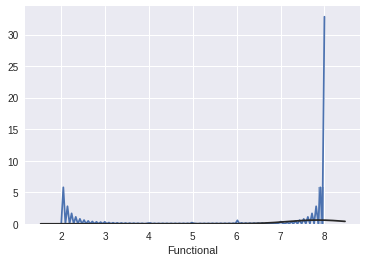

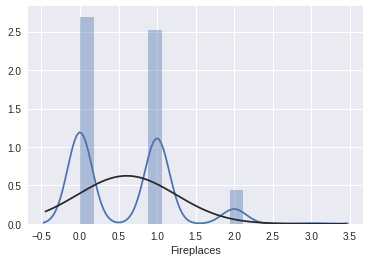

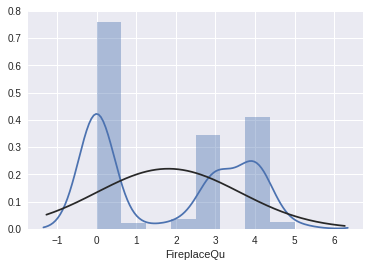

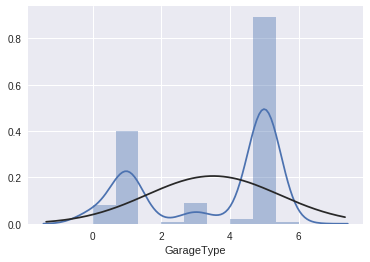

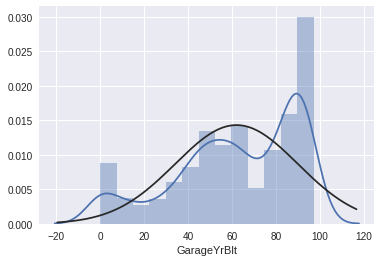

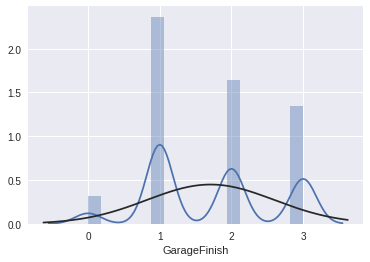

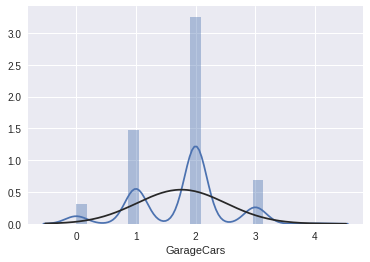

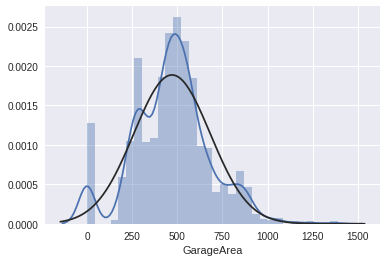

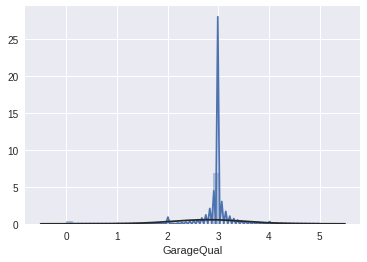

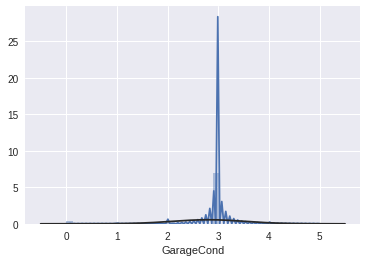

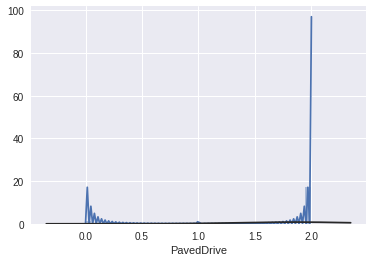

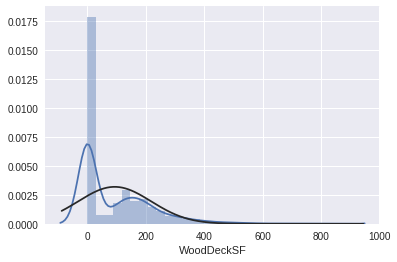

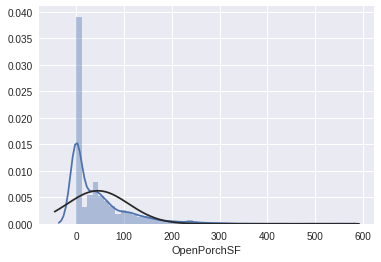

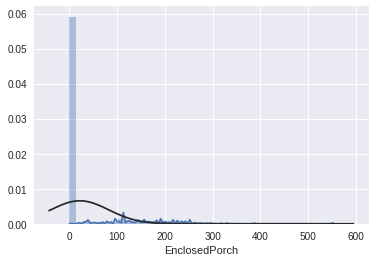

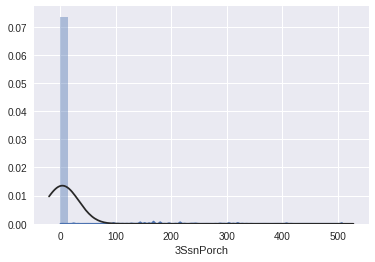

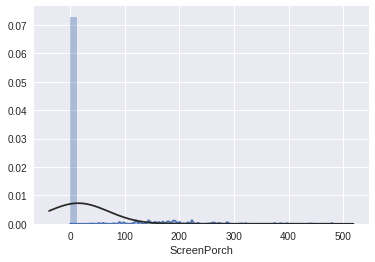

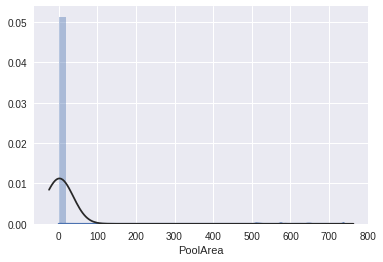

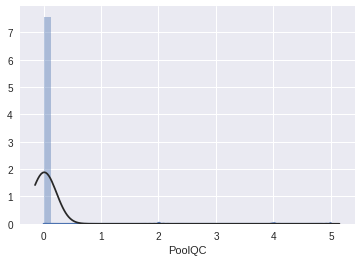

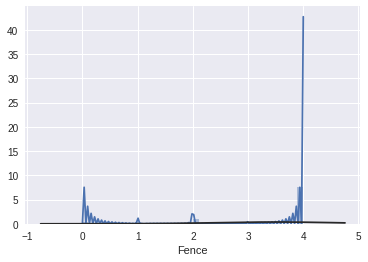

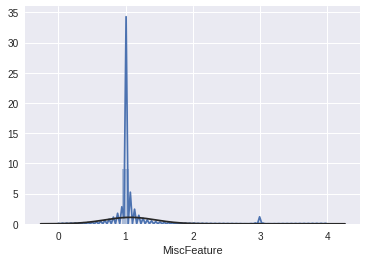

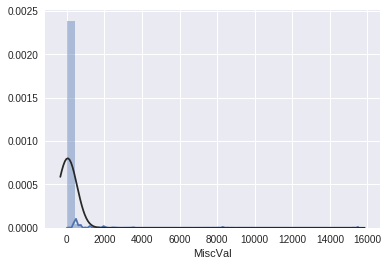

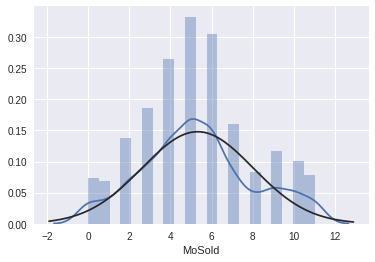

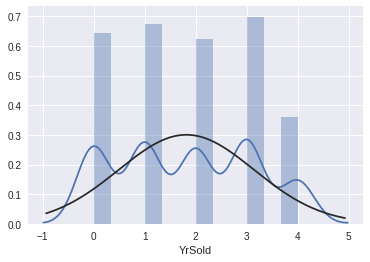

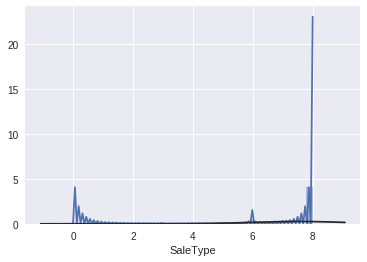

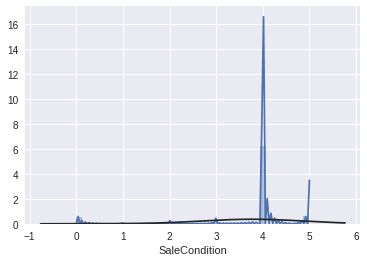

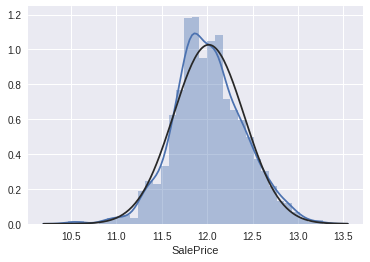

In [16]:
# In the search for normality
from scipy.stats import norm
import scipy.stats as stats

def Normal_observe(feature):
    sns.distplot(df_train[feature],fit=norm)
    fig = plt.figure()
#     res = stats.probplot(df_train[feature],plot=plt)

for feature in df_train.columns:
    Normal_observe(feature)

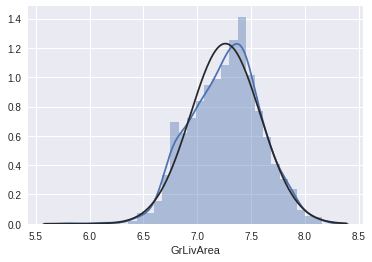

In [17]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
Normal_observe('GrLivArea')

In [18]:
feature_list = ['OverallQual']
simple_linear_test(df_train,5,feature_list)

TRAIN: 1157 TEST: 290
1 part RMSE: 0.3831298
TRAIN: 1157 TEST: 290
2 part RMSE: 0.4130983
TRAIN: 1158 TEST: 289
3 part RMSE: 0.3973682
TRAIN: 1158 TEST: 289
4 part RMSE: 220.2850548
TRAIN: 1158 TEST: 289
5 part RMSE: 0.3751219
Avg RMSE :  44.3707546113


In [19]:
df_train['OverallQual'].describe()

count    1447.000000
mean        6.078093
std         1.358386
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

In [20]:
# Normalize some categorical data
df_train['OverallQual'] = df_train['OverallQual']/10

In [21]:
df_train['YearBuilt'].describe()

count    1447.000000
mean       72.878369
std        28.799908
min         0.000000
25%        55.000000
50%        73.000000
75%       101.000000
max       111.000000
Name: YearBuilt, dtype: float64

In [22]:
df_train['YearBuilt'] = df_train['YearBuilt']/111

In [23]:
df_train['YearRemodAdd'].describe()

count    1447.000000
mean       34.767795
std        20.655810
min         0.000000
25%        16.000000
50%        43.000000
75%        54.000000
max        60.000000
Name: YearRemodAdd, dtype: float64

In [24]:
df_train['YearRemodAdd'] = df_train['YearRemodAdd']/60

In [25]:
df_train['MasVnrArea'].describe()

count    1447.000000
mean       57.210090
std        88.432845
min         0.000000
25%         0.000000
50%         0.000000
75%       104.500000
max       326.000000
Name: MasVnrArea, dtype: float64

In [26]:
df_train['MasVnrArea'] = (df_train['MasVnrArea']/326)**1.5

In [27]:
feature_list = ['YearBuilt','MasVnrArea']
simple_linear_test(df_train,10,feature_list)

TRAIN: 1302 TEST: 145
1 part RMSE: 76.8089380
TRAIN: 1302 TEST: 145
2 part RMSE: 104.0167100
TRAIN: 1302 TEST: 145
3 part RMSE: 1.3955460
TRAIN: 1302 TEST: 145
4 part RMSE: 11.2931943
TRAIN: 1302 TEST: 145
5 part RMSE: 9.7021135
TRAIN: 1302 TEST: 145
6 part RMSE: 23.8303702
TRAIN: 1302 TEST: 145
7 part RMSE: 0.3997623
TRAIN: 1303 TEST: 144
8 part RMSE: 27.8833509
TRAIN: 1303 TEST: 144
9 part RMSE: 10.3987978
TRAIN: 1303 TEST: 144
10 part RMSE: 26.9116642
Avg RMSE :  29.2640447212


In [28]:
df_train['Foundation'].describe()

count    1447.00000
mean        1.39461
std         0.72291
min         0.00000
25%         1.00000
50%         1.00000
75%         2.00000
max         5.00000
Name: Foundation, dtype: float64

In [29]:
df_train['Foundation'] = df_train['Foundation']/5

In [30]:
feature_list = ['YearBuilt','MasVnrArea','Foundation']
simple_linear_test(df_train,5,feature_list)

TRAIN: 1157 TEST: 290
1 part RMSE: 88.1788534
TRAIN: 1157 TEST: 290
2 part RMSE: 1.6638504
TRAIN: 1158 TEST: 289
3 part RMSE: 75.0344963
TRAIN: 1158 TEST: 289
4 part RMSE: 2.3298337
TRAIN: 1158 TEST: 289
5 part RMSE: 32.5133568
Avg RMSE :  39.9440781384


In [31]:
df_train['ExterQual'].describe()

count    1447.000000
mean        3.389772
std         0.569006
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: ExterQual, dtype: float64

In [32]:
df_train['ExterQual'] = df_train['ExterQual']/3

In [33]:
feature_list = ['YearBuilt','MasVnrArea','Foundation','ExterQual']
simple_linear_test(df_train,5,feature_list)

TRAIN: 1157 TEST: 290
1 part RMSE: 12.9392096
TRAIN: 1157 TEST: 290
2 part RMSE: 12.4368894
TRAIN: 1158 TEST: 289
3 part RMSE: 86.2804886
TRAIN: 1158 TEST: 289
4 part RMSE: 59.3883519
TRAIN: 1158 TEST: 289
5 part RMSE: 543.8429992
Avg RMSE :  142.977587748


In [41]:
# compare to original
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.8,
                 gamma=0.0,
                 learning_rate=0.001,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.8,
                 seed=42,
                 silent=False)
# create new training set by previous feature selection
X_data = pd.concat([df_train['GrLivArea'],df_train['GarageArea'],df_train['TotalBsmtSF'],df_train['OverallQual'],df_train['FullBath'],df_train['Fireplaces'],df_train['YearBuilt'],df_train['YearRemodAdd']],axis=1)
y_data = df_train['SalePrice']
#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.2,random_state=0)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print("XGBoost score on training set: ", rmse(y_test, y_pred))

XGBoost score on training set:  0.131029952423


In [36]:
#df_train['TotalBsmtSF']

In [42]:
#create prediction csv
df_test = pd.read_csv('test.csv')
#transfer data
df_test['GrLivArea'] = np.log(df_train['GrLivArea'])
X_data = pd.concat([df_test['GrLivArea'],df_test['GarageArea'],df_test['TotalBsmtSF'],df_test['OverallQual'],df_test['FullBath'],df_test['Fireplaces'],df_test['YearBuilt'],df_test['YearRemodAdd']],axis=1)

y_pred_data = regr.predict(X_data)
y_pred_data = np.exp(y_pred_data)

pd.DataFrame({'Id': df_test['Id'], 'SalePrice':y_pred_data}).to_csv('result.csv', index =False) 

In [37]:
# test Area code reference
# ----
# MasVnrType_dist = df_train['MasVnrType'].value_counts()
# print (MasVnrType_dist)
# df_train.loc[df_train['MasVnrType'].isnull()].loc[:,['MasVnrType','MasVnrArea']]
# ----
# df_train.loc[df_train['BsmtExposure'].isnull()].loc[948,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]
# ----
# m = df_train.loc[df_train['BsmtFinType1']=='Unf'].loc[:,['BsmtExposure','BsmtFinType1','BsmtFinType2']]
# m['BsmtExposure'].value_counts()
# ----
# df_train.loc[df_train['BsmtFinType2'].isnull()].loc[332,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]
# ----
# df_train.loc[df_train['GarageType'].isnull()].loc[:,['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].count()
# ----
# df_train['GarageYrBlt'].describe()